[*********************100%***********************]  5 of 5 completed

Data fetching completed! Data shape: (252, 5)
Preprocessing completed! Return data shape: (251, 5)
Metrics calculated successfully!
Portfolio optimization successful!

Optimized Portfolio Weights:
UBER: 0.0670
AMD: 0.6268
NVDA: 0.0000
AMZN: 0.0569
TSLA: 0.2493

Expected Portfolio Return: 0.0013
Expected Portfolio Volatility: 0.0159


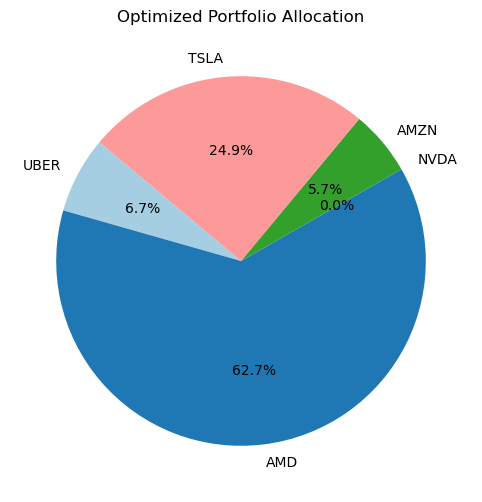

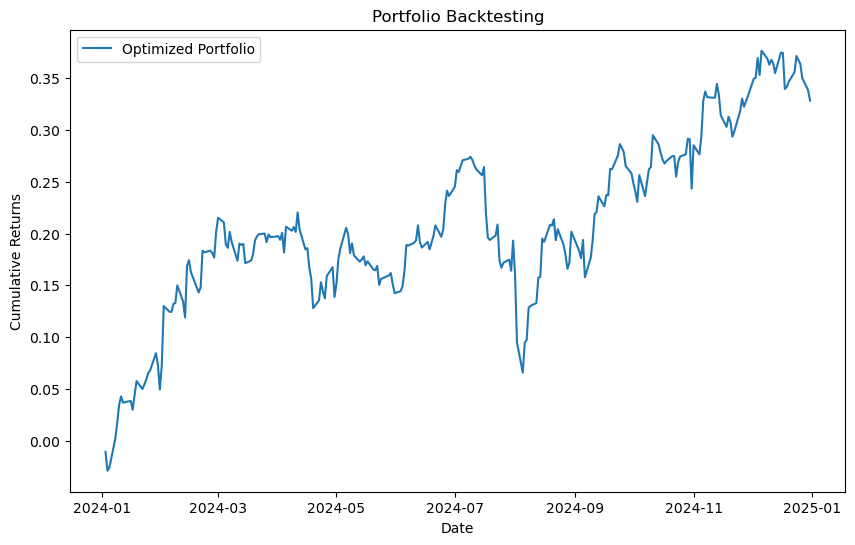

In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

class PortfolioOptimization:
    def __init__(self, tickers, start_date, end_date):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.returns = None
        self.mean_returns = None
        self.cov_matrix = None
        self.optimized_weights = None

    def fetch_data(self):
        """
        Fetch historical stock data from Yahoo Finance and extract closing prices.
        """
        try:
            df = yf.download(self.tickers, start=self.start_date, end=self.end_date)
            
            # Check if 'Adj Close' exists; otherwise, use 'Close'
            if 'Adj Close' in df.columns:
                self.data = df['Adj Close']
            elif ('Close' in df.columns.levels[0]):  # Multi-index case
                self.data = df['Close']
            else:
                print("Error: Neither 'Adj Close' nor 'Close' column found. Check data structure!")
                print(df.head())  # Debugging output
                return
            
            print("Data fetching completed! Data shape:", self.data.shape)

        except Exception as e:
            print(f"Error fetching data: {e}")

    def preprocess_data(self):
        """
        Calculate daily returns from the price data.
        """
        if self.data is None or self.data.empty:
            print("Error: No data available for preprocessing.")
            return
        
        self.returns = self.data.pct_change().dropna()
        print("Preprocessing completed! Return data shape:", self.returns.shape)

    def calculate_metrics(self):
        """
        Compute mean returns and covariance matrix for optimization.
        """
        if self.returns is None or self.returns.empty:
            print("Error: No return data available.")
            return
        
        self.mean_returns = self.returns.mean()
        self.cov_matrix = self.returns.cov()
        print("Metrics calculated successfully!")

    def optimize_portfolio(self):
        """
        Optimize portfolio by minimizing volatility using SciPy optimization.
        """
        if self.mean_returns is None or self.cov_matrix is None:
            print("Error: Missing data for optimization.")
            return
        
        num_assets = len(self.tickers)
        weights = np.ones(num_assets) / num_assets  # Initial equal weights
        constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # Sum of weights = 1
        bounds = [(0, 1) for _ in range(num_assets)]  # Weights between 0 and 1

        def portfolio_volatility(weights):
            return np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights)))

        result = minimize(portfolio_volatility, weights, bounds=bounds, constraints=constraints)

        if result.success:
            self.optimized_weights = result.x
            print("Portfolio optimization successful!")
        else:
            print("Error in optimization:", result.message)

    def display_metrics(self):
        """
        Display portfolio metrics.
        """
        if self.optimized_weights is None:
            print("Error: No optimized weights found.")
            return
        
        print("\nOptimized Portfolio Weights:")
        for ticker, weight in zip(self.tickers, self.optimized_weights):
            print(f"{ticker}: {weight:.4f}")

        expected_return = np.dot(self.optimized_weights, self.mean_returns)
        expected_volatility = np.sqrt(np.dot(self.optimized_weights.T, np.dot(self.cov_matrix, self.optimized_weights)))

        print(f"\nExpected Portfolio Return: {expected_return:.4f}")
        print(f"Expected Portfolio Volatility: {expected_volatility:.4f}")

    def visualize_weights(self):
        """
        Visualize optimized portfolio weights using a pie chart.
        """
        if self.optimized_weights is None:
            print("Error: No optimized weights to display.")
            return

        plt.figure(figsize=(8, 6))
        plt.pie(self.optimized_weights, labels=self.tickers, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
        plt.title("Optimized Portfolio Allocation")
        plt.show()

    def backtest_portfolio(self):
        """
        Backtest the optimized portfolio by calculating cumulative returns.
        """
        if self.returns is None or self.optimized_weights is None:
            print("Error: No data available for backtesting.")
            return

        cumulative_returns = (self.returns @ self.optimized_weights).cumsum()
        plt.figure(figsize=(10, 6))
        plt.plot(cumulative_returns, label="Optimized Portfolio")
        plt.xlabel("Date")
        plt.ylabel("Cumulative Returns")
        plt.title("Portfolio Backtesting")
        plt.legend()
        plt.show()

# -------------------------
# Initialize and Run Portfolio Optimization
# -------------------------

tickers = ["UBER", "AMD", "NVDA", "AMZN", "TSLA"]
start_date = "2024-01-01"
end_date = "2025-01-01"

portfolio = PortfolioOptimization(tickers, start_date, end_date)

# Fetch and preprocess data
portfolio.fetch_data()
portfolio.preprocess_data()

# Calculate metrics and optimize portfolio
portfolio.calculate_metrics()
portfolio.optimize_portfolio()

# Display results
portfolio.display_metrics()
portfolio.visualize_weights()
portfolio.backtest_portfolio()
